In [1]:
import matplotlib.pyplot as plt
import scipy.io as io
import numpy as np
import copy
import pandas as pd

import os
import glob

Okay so, when I ran the code on the ~2000 images, I found that the cropping method had an error of about 10%. That is, 
of the 2000 ish images, 200 or so would not have the expected cropping behavior. So, this code goes through the process step by step, 
and compares a file that I know will be cropped propperly, and one that I know has failed. 

The goal is to see if I can identify the issue. 

In [2]:
import sys
sys.path.insert(1, '../../src')
import preprocess_filter

In [3]:
training_df = pd.read_csv('jupyter_testing/resolution_test/training_image_resolution.csv')
training_df

opus_id  x_length  y_length             folder  \
0             W1630641951      1488       281  117_SPKMVLFHP_005   
1             W1630637151      1488       285  117_SPKMVLFHP_005   
2             W1630646151      1488       283  117_SPKMVLFHP_005   
3     bad_bad_W1630655751      1442      1108  117_SPKMVLFHP_005   
4             W1630639551      1488       285  117_SPKMVLFHP_005   
...                   ...       ...       ...                ...   
1878          W1597976395      1488       601      081_SPKMVLFLP   
1879          W1598009545      1488       494      081_SPKMVLFLP   
1880          W1598003695      1488       517      081_SPKMVLFLP   
1881          W1598000770      1488       524      081_SPKMVLFLP   
1882          W1597994920      1488       542      081_SPKMVLFLP   

                                              full_path  pixel_error  
0     ../../../data/2023_imagery/filtered/117_SPKMVL...           55  
1     ../../../data/2023_imagery/filtered/117_SPKMVL...           51  
2     ../../../data/2023_imagery/filtered/117_SPKMVL...           53  
3     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
4     ../../../data/2023_imagery/filtered/117_SPKMVL...           51  
...                                                 ...          ...  
1878  ../../../data/2023_imagery/filtered/081_SPKMVL...          265  
1879  ../../../data/2023_imagery/filtered/081_SPKMVL...          158  
1880  ../../../data/2023_imagery/filtered/081_SPKMVL...          181  
1881  ../../../data/2023_imagery/filtered/081_SPKMVL...          188  
1882  ../../../data/2023_imagery/filtered/081_SPKMVL...          206  

[1883 rows x 6 columns]

In [4]:
# grabbing the bad ones

bad_df = training_df[training_df.opus_id.str.contains('bad')]
bad_df

opus_id  x_length  y_length             folder  \
3     bad_bad_W1630655751      1442      1108  117_SPKMVLFHP_005   
7     bad_bad_W1630673151      1408      1108  117_SPKMVLFHP_005   
8     bad_bad_W1630674951      1388      1108  117_SPKMVLFHP_005   
9     bad_bad_W1630661151      1435      1108  117_SPKMVLFHP_005   
10    bad_bad_W1630663551      1425      1108  117_SPKMVLFHP_005   
...                   ...       ...       ...                ...   
1114  bad_bad_W1630835909      1488      1043  117_SPKMVLFHP_007   
1115  bad_bad_W1630868429      1488      1083  117_SPKMVLFHP_007   
1116  bad_bad_W1630842413      1488      1065  117_SPKMVLFHP_007   
1117  bad_bad_W1630838619      1488      1065  117_SPKMVLFHP_007   
1118  bad_bad_W1630861383      1488      1086  117_SPKMVLFHP_007   

                                              full_path  pixel_error  
3     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
7     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
8     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
9     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
10    ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
...                                                 ...          ...  
1114  ../../../data/2023_imagery/filtered/117_SPKMVL...          707  
1115  ../../../data/2023_imagery/filtered/117_SPKMVL...          747  
1116  ../../../data/2023_imagery/filtered/117_SPKMVL...          729  
1117  ../../../data/2023_imagery/filtered/117_SPKMVL...          729  
1118  ../../../data/2023_imagery/filtered/117_SPKMVL...          750  

[203 rows x 6 columns]

In [5]:
bad_df.opus_id = bad_df.opus_id.str.replace("bad_bad_", "")
bad_df

/Users/willbyrne/opt/anaconda3/envs/unet/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


opus_id  x_length  y_length             folder  \
3     W1630655751      1442      1108  117_SPKMVLFHP_005   
7     W1630673151      1408      1108  117_SPKMVLFHP_005   
8     W1630674951      1388      1108  117_SPKMVLFHP_005   
9     W1630661151      1435      1108  117_SPKMVLFHP_005   
10    W1630663551      1425      1108  117_SPKMVLFHP_005   
...           ...       ...       ...                ...   
1114  W1630835909      1488      1043  117_SPKMVLFHP_007   
1115  W1630868429      1488      1083  117_SPKMVLFHP_007   
1116  W1630842413      1488      1065  117_SPKMVLFHP_007   
1117  W1630838619      1488      1065  117_SPKMVLFHP_007   
1118  W1630861383      1488      1086  117_SPKMVLFHP_007   

                                              full_path  pixel_error  
3     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
7     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
8     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
9     ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
10    ../../../data/2023_imagery/filtered/117_SPKMVL...          772  
...                                                 ...          ...  
1114  ../../../data/2023_imagery/filtered/117_SPKMVL...          707  
1115  ../../../data/2023_imagery/filtered/117_SPKMVL...          747  
1116  ../../../data/2023_imagery/filtered/117_SPKMVL...          729  
1117  ../../../data/2023_imagery/filtered/117_SPKMVL...          729  
1118  ../../../data/2023_imagery/filtered/117_SPKMVL...          750  

[203 rows x 6 columns]

In [6]:
exp_opus_id = bad_df.iloc[0, 0]

In [7]:
example_rpjb = glob.glob(f'../data/2023_rpjb/good/*/{exp_opus_id}*')[0]
example_rpjb

'../data/2023_rpjb/good/117_SPKMVLFHP_005/W1630655751_1_CALIB.rpjb'

# Imitating preprocess_filter

In [8]:
# lets compare how a good image perfroms vs how a bad image performs
idl = io.readsav(example_rpjb)
bad_pv = idl.rrpi
bad_pv=copy.copy(bad_pv)
bad_y, bad_x = bad_pv.shape

### Initial compare

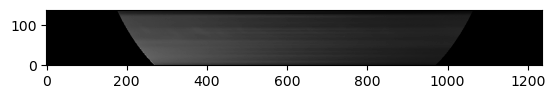

In [9]:
# pretty dark, maybe a cosmic ray?
plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

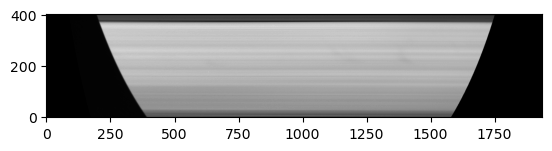

In [10]:
# example of a good image
idl = io.readsav('../data/2023_rpjb/good/085_SPKMVLFLP/W1600545658_1_CALIB.rpjb')
good_pv = idl.rrpi
good_pv=copy.copy(good_pv)
good_y, good_x = good_pv.shape
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### Remove cosmic ray

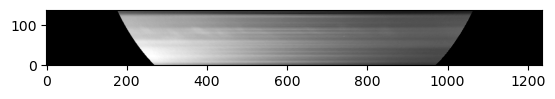

In [11]:
# Woah, so it looks like there was a cosmic ray in the image. This may have caused the cropping issue. 
bad_pv = preprocess_filter.remove_cosmic_rays(bad_pv)
plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

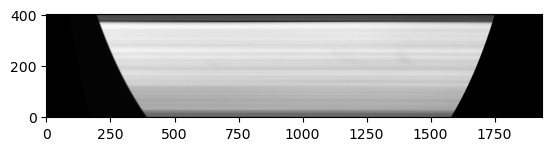

In [12]:
good_pv = preprocess_filter.remove_cosmic_rays(good_pv)
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### Quantize Prep

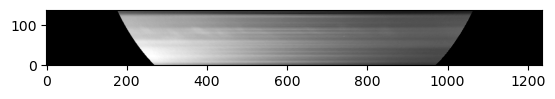

In [13]:
# again, looks fine
flt = bad_pv.flatten()
p_std = flt.std()
p_m = flt.mean()
bad_pv[bad_pv < (p_m - p_std)] = 0

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

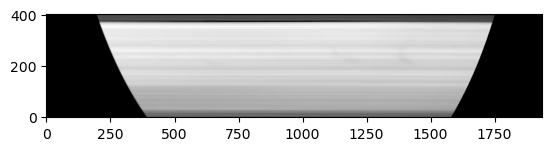

In [14]:
flt = good_pv.flatten()
p_std = flt.std()
p_m = flt.mean()
good_pv[good_pv < (p_m - p_std)] = 0

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### create quant map

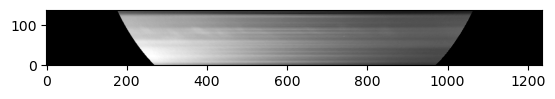

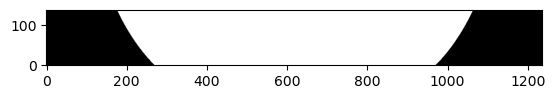

In [15]:
# so far, so good
bad_pv, bad_quant = preprocess_filter.apply_quantize(bad_pv)

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()
plt.imshow(bad_quant, cmap='gray', origin='lower')
plt.show()

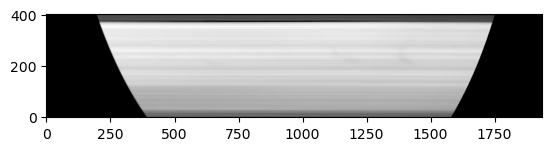

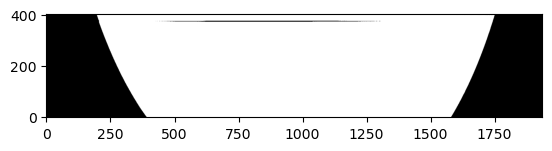

In [16]:
good_pv, good_quant = preprocess_filter.apply_quantize(good_pv)

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()
plt.imshow(good_quant, cmap='gray', origin='lower')
plt.show()

### Quant cropping

{'x_start': 261, 'x_end': 980, 'biggest_sum': 720, 'y_longst_top': 9}


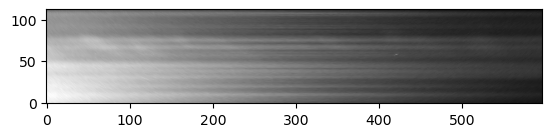

In [17]:
# it seems that the new remove cosmic ray method has solved the problem. looks, these are perfect
LS = preprocess_filter.get_quant_stats(bad_quant)
print(LS)


ybuffer = int(bad_y*.1)
xbuffer = int(bad_x*.05)
bad_pv = bad_pv[ybuffer:bad_y-ybuffer, LS["x_start"]+xbuffer:LS["x_end"]-xbuffer]

plt.imshow(bad_pv, cmap='gray', origin='lower')
plt.show()

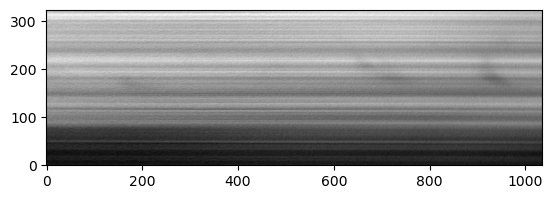

In [18]:
LS = preprocess_filter.get_quant_stats(good_quant)


ybuffer = int(good_y*.1)
xbuffer = int(good_x*.05)
good_pv = good_pv[ybuffer:good_y-ybuffer, LS["x_start"]+xbuffer:LS["x_end"]-xbuffer]

plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

### now, lets check out this new buffer method I wrote

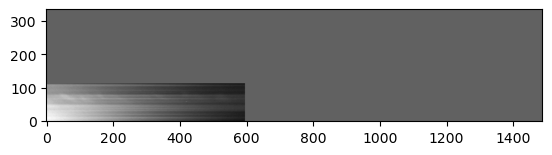

In [19]:
# Ya so uh, that doesn't look great.

bad_pv = preprocess_filter.buffer_image(bad_pv, propper_x=1488, propper_y=336)
plt.imshow(bad_pv, cmap='gray', origin='lower')

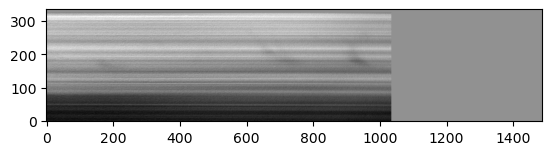

In [20]:
good_pv = preprocess_filter.buffer_image(good_pv, propper_x=1488, propper_y=336)
plt.imshow(good_pv, cmap='gray', origin='lower')

### Forrier time!

In [21]:
import sys
sys.path.insert(1, '../../../spokes_gridtools/Research2022/spokes/src')
import spoketools

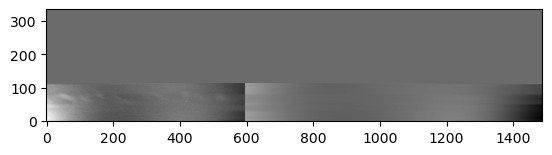

In [22]:
# Ew, this is so ugly
bad_pv = spoketools.fft2lpf(bad_pv,0, 3 )
plt.imshow(bad_pv, cmap='gray', origin='lower')

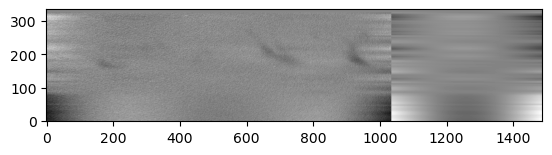

In [23]:
good_pv = spoketools.fft2lpf(good_pv, 0, 3)
plt.imshow(good_pv, cmap='gray', origin='lower')

### Lucy median filter??

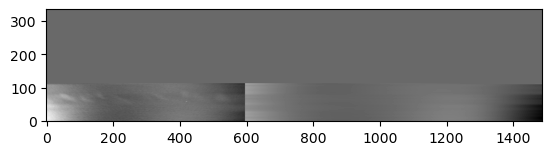

In [24]:
bad_pv = preprocess_filter.apply_lucy_median(bad_pv)
plt.imshow(bad_pv, cmap='gray', origin='lower')

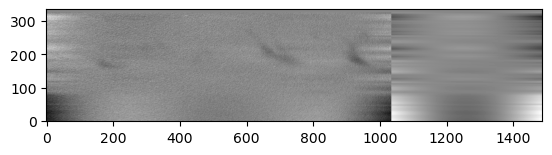

In [25]:
good_pv = preprocess_filter.apply_lucy_median(good_pv)
plt.imshow(good_pv, cmap='gray', origin='lower')

In [26]:
bad_rpjb_list = []

for opus_id in bad_df.opus_id:
    rpjb_potential_list = glob.glob(f'../data/2023_rpjb/good/*/{opus_id}*')
    if len(rpjb_potential_list) == 1:
        bad_rpjb_path = rpjb_potential_list[0]
        bad_rpjb_list.append(bad_rpjb_path)
    elif len(rpjb_potential_list) == 0:
        print("path doesn't exist")
    else:
        print("there were multiple!")

print(len(bad_df.opus_id))
print(len(bad_rpjb_list))

203
203


In [27]:
import preprocess_filter

W1630655751


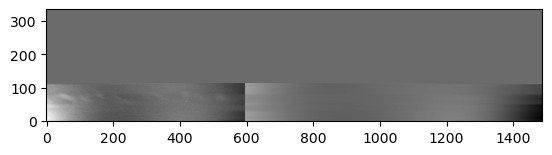

W1630673151


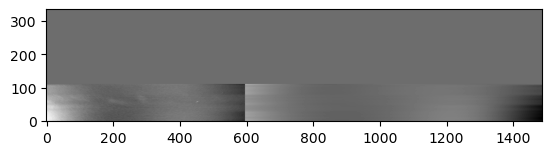

W1630674951


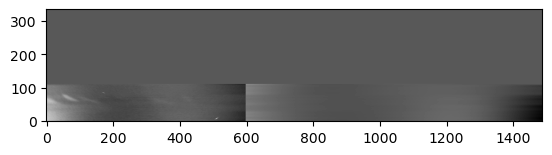

W1630661151


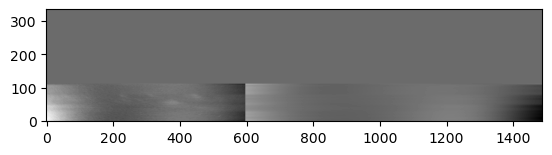

W1630663551


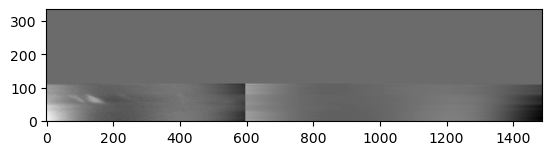

W1630650951


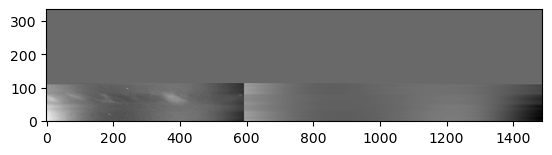

W1630657551


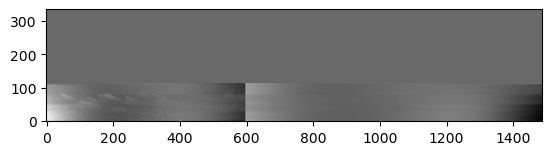

W1630668951


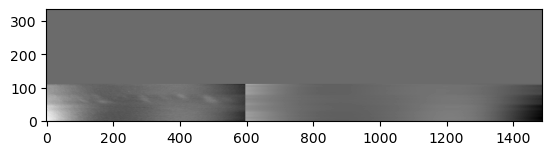

W1630655151


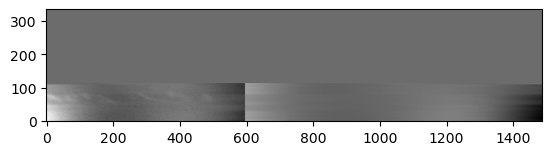

W1630661751


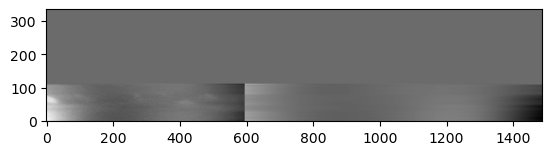

W1630673751


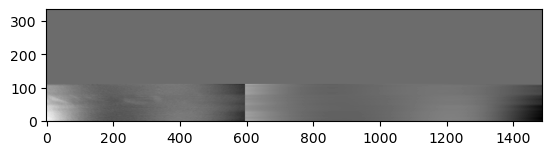

W1630659351


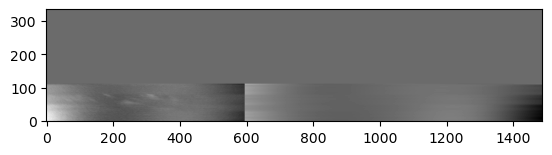

W1630671351


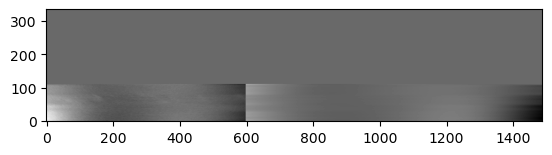

W1630669551


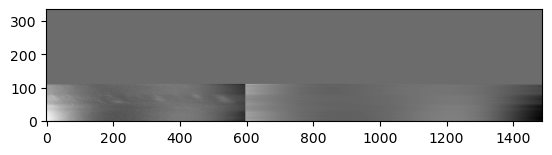

W1630656951


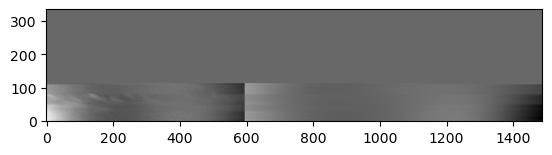

W1630667151


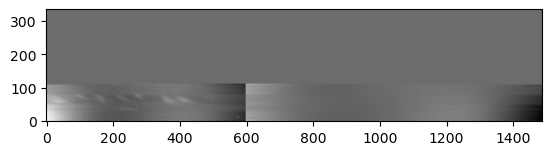

W1630677351


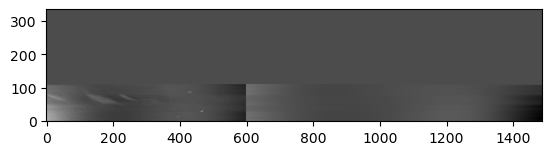

W1630665351


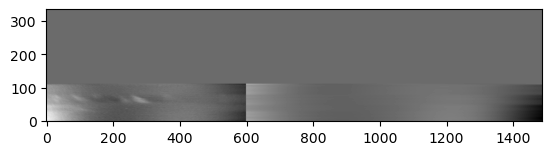

W1630667751


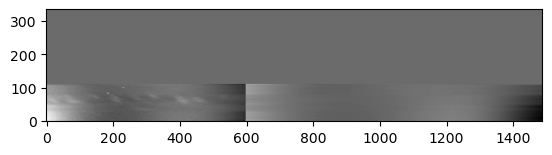

W1630675551


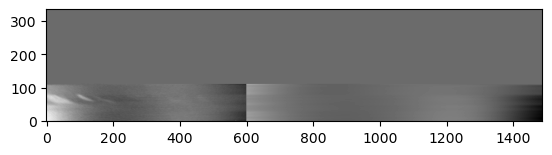

W1630651551


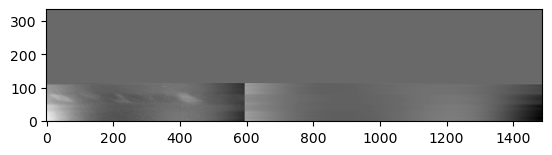

W1630662951


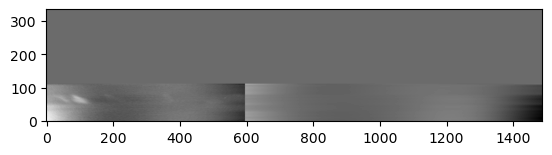

W1630654551


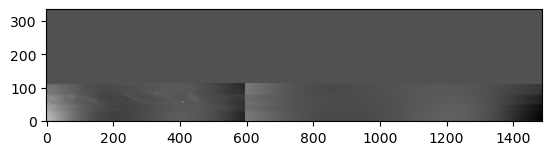

W1630658751


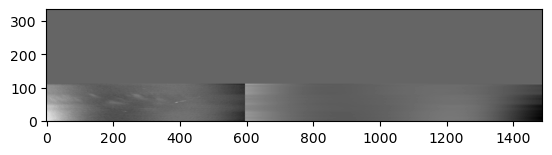

W1630670751


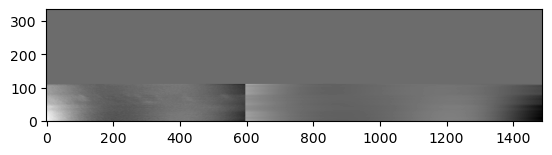

W1630656351


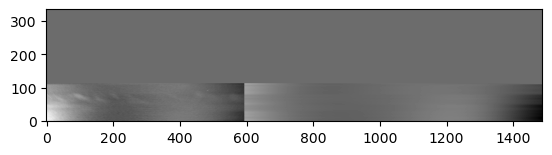

W1630653951


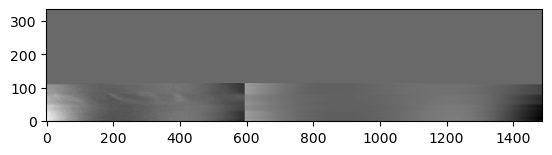

W1630658151


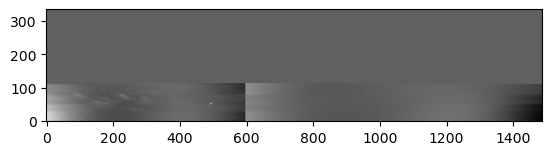

W1630672551


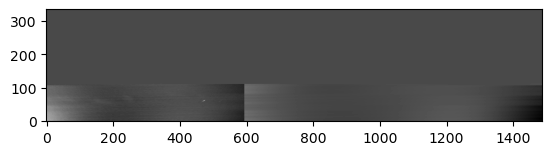

W1630660551


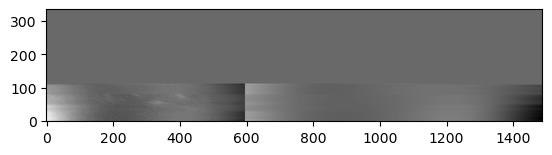

W1630665951


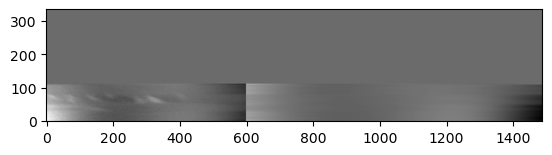

W1630670151


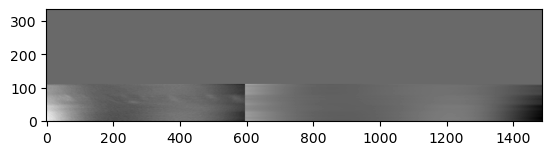

W1630676751


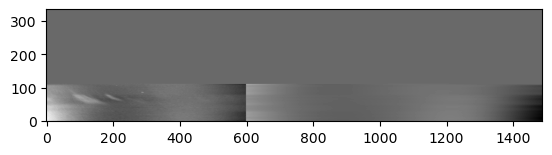

W1630664751


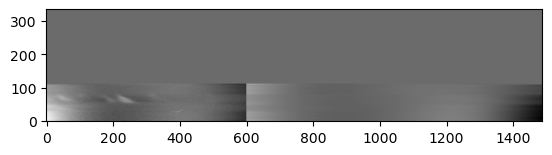

W1630674351


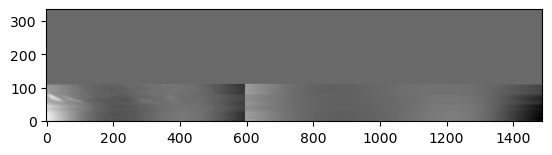

W1630664151


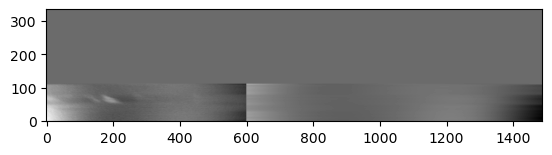

W1630671951


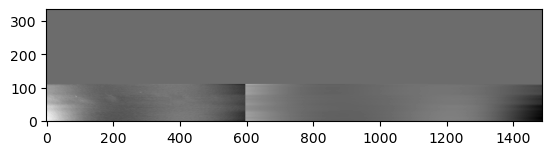

W1630676151


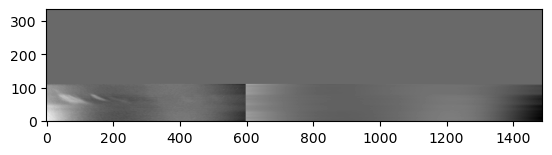

W1630666551


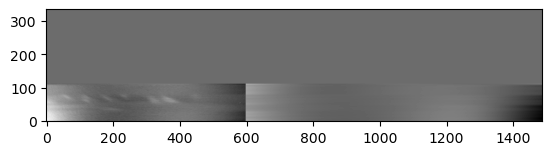

W1630659951


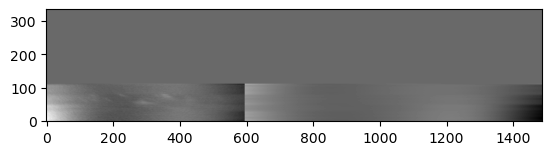

W1630678551


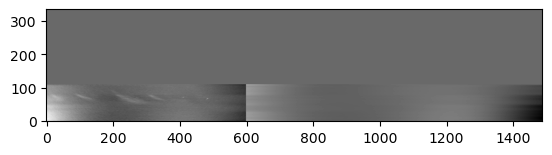

W1630668351


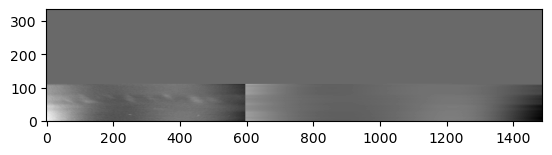

W1630576041


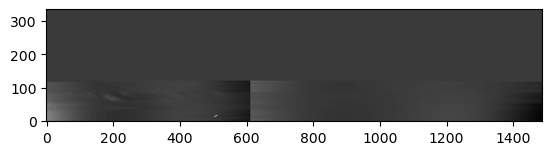

W1630586301


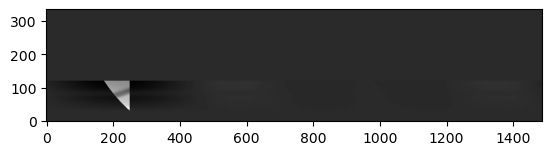

W1630565781


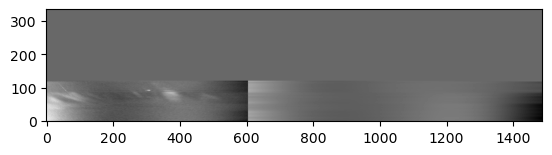

W1630480510


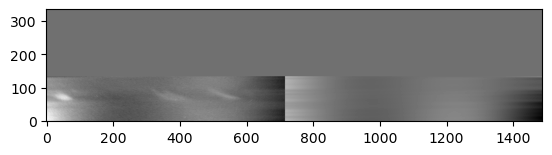

W1630477610


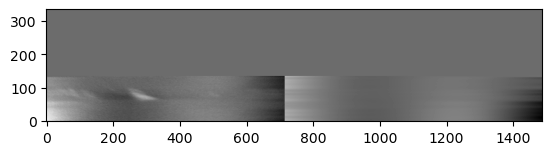

W1630476450


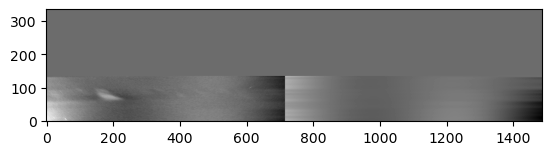

W1630482830


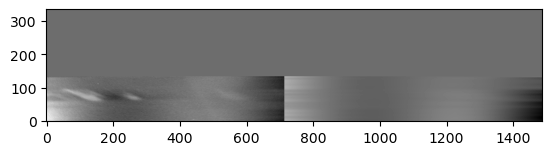

W1630479930


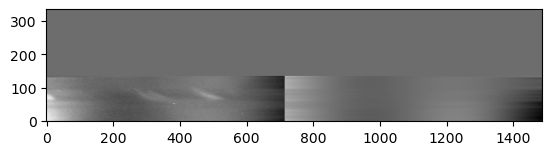

W1630481090


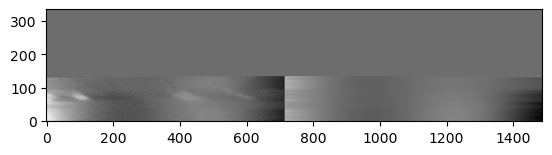

W1630478190


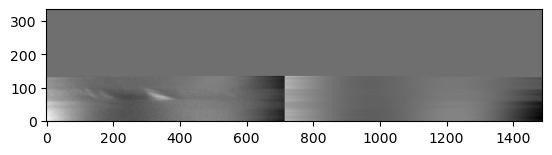

W1630478770


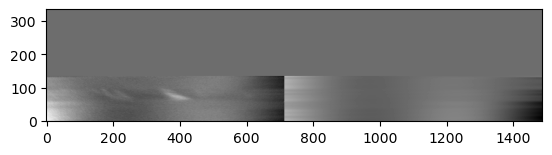

W1630481670


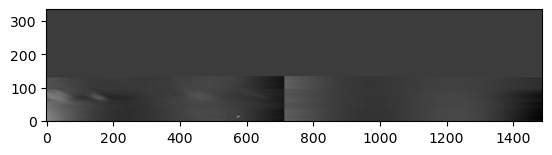

W1630482250


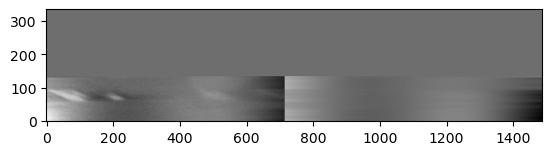

W1630477030


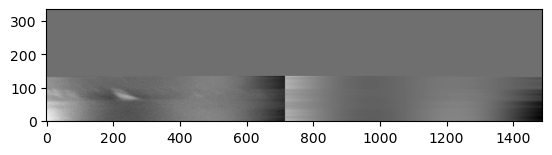

W1630483410


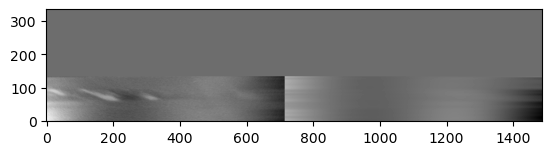

W1630479350


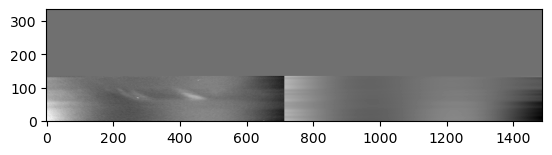

W1630743244


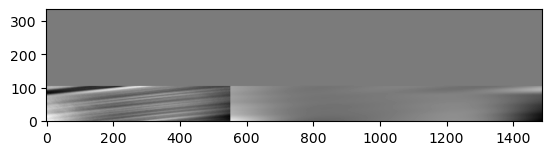

W1630744885


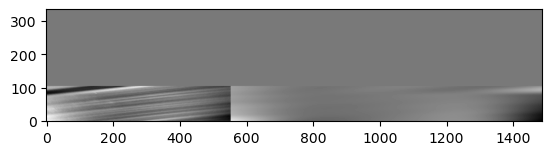

W1630744338


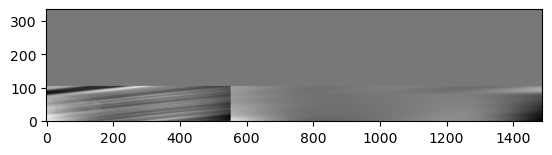

W1630748714


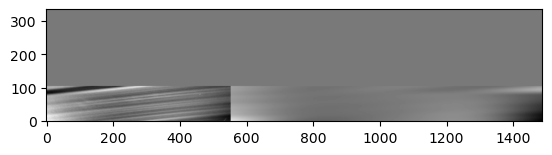

W1630741056


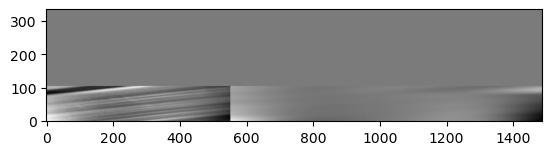

W1630733398


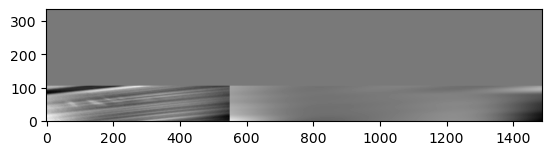

W1630756919


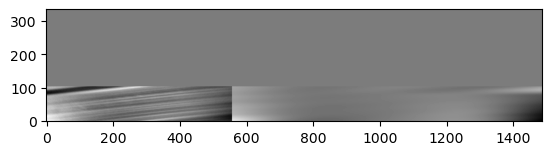

W1630733945


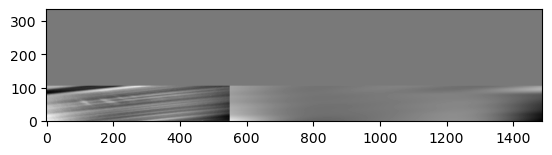

W1630745432


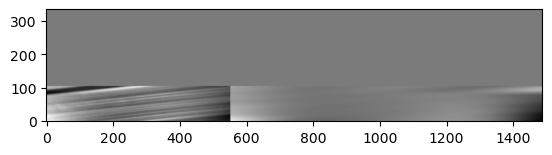

W1630731210


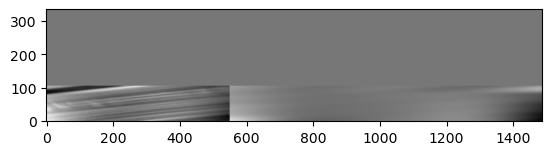

W1630747620


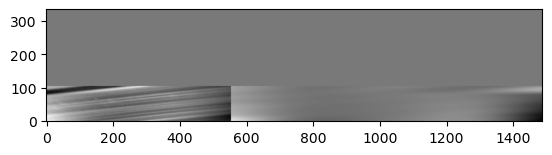

W1630753090


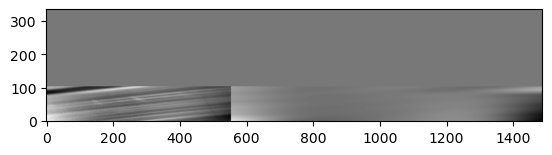

W1630756372


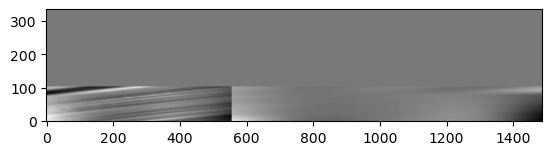

W1630739415


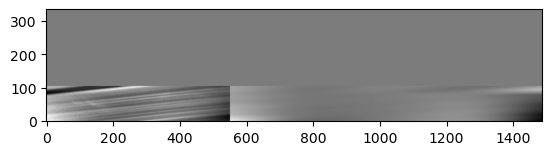

W1630724646


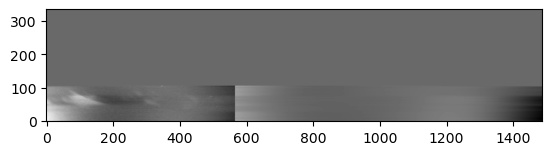

W1630735039


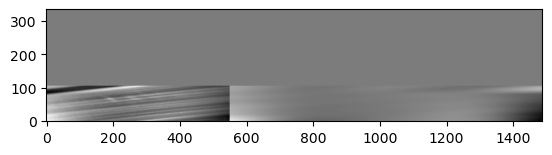

W1630748167


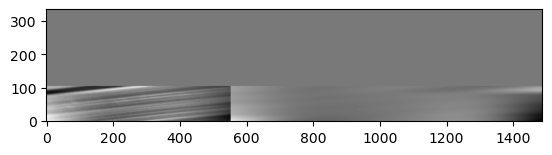

W1630726287


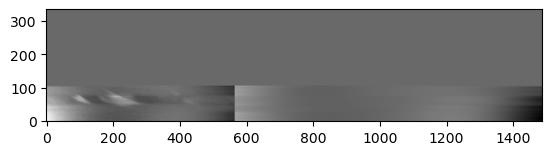

W1630736133


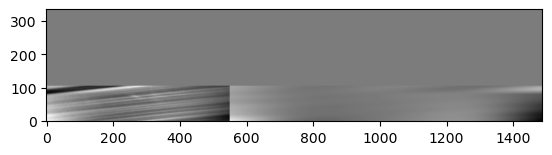

W1630758013


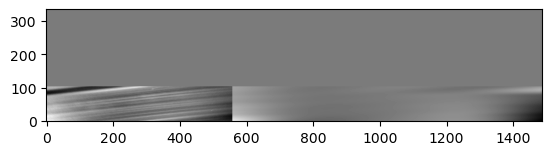

W1630755278


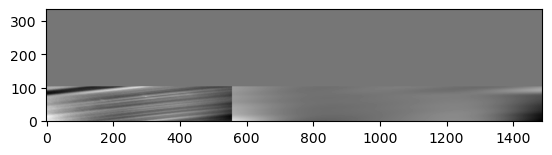

W1630737774


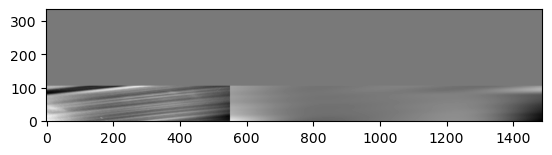

W1630743791


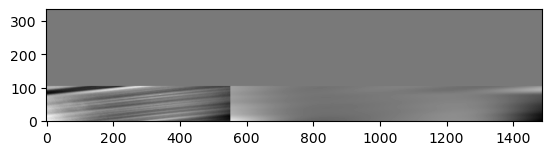

W1630758560


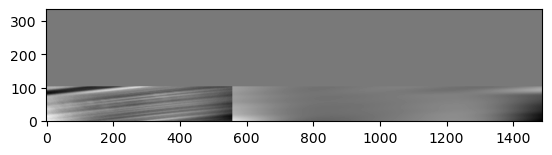

W1630734492


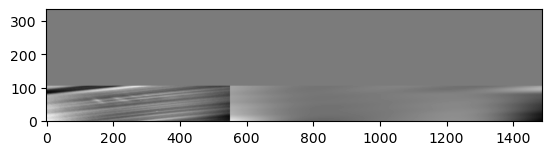

W1630753637


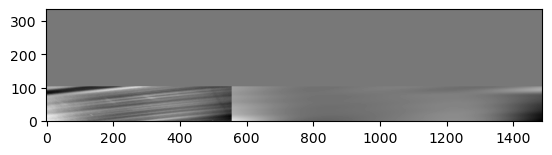

W1630736680


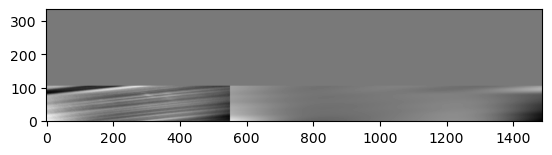

W1630729022


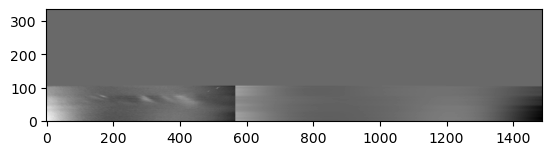

W1630742697


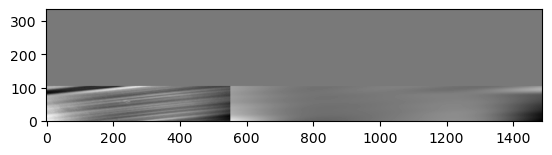

W1630739962


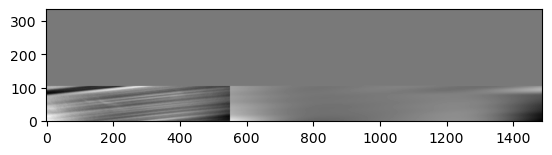

W1630724099


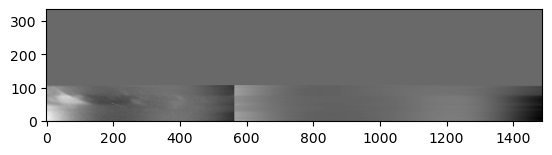

W1630749261


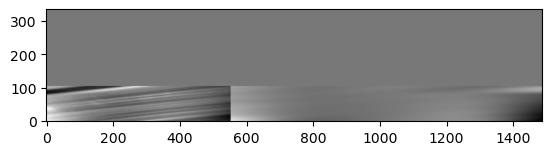

W1630725740


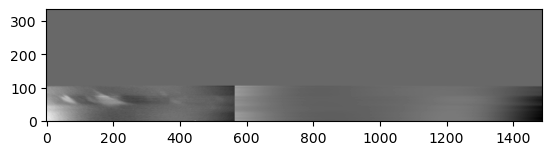

W1630757466


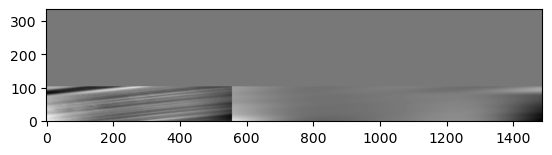

W1630754184


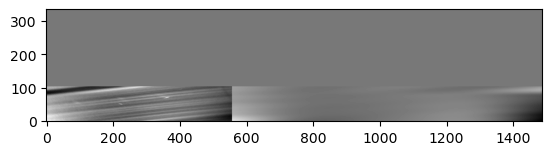

W1630759107


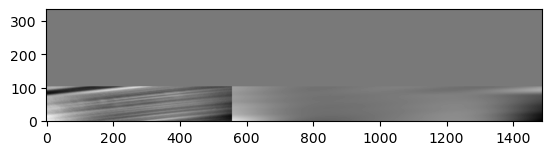

W1630750902


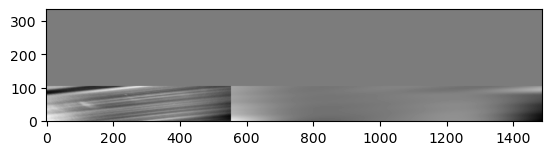

W1630747073


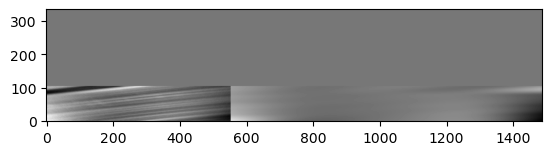

W1630737227


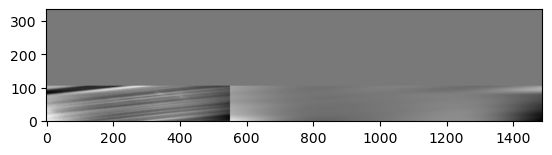

W1630728475


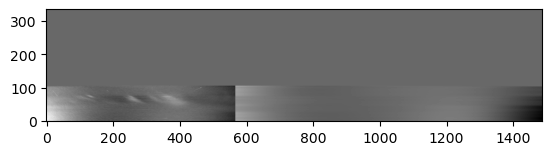

W1630729569


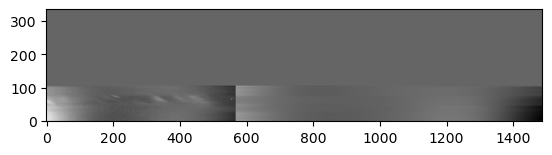

W1630727381


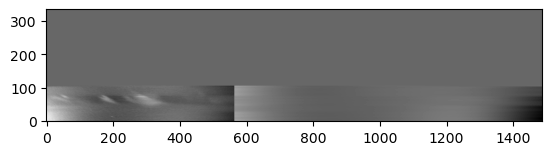

W1630751996


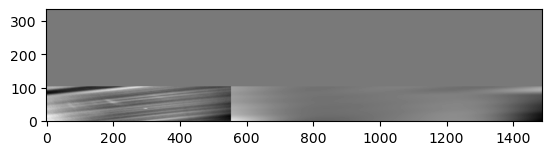

W1630735586


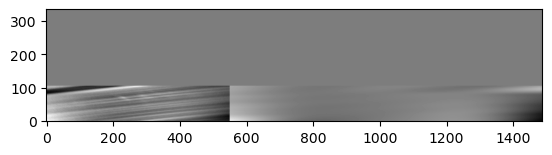

W1630741603


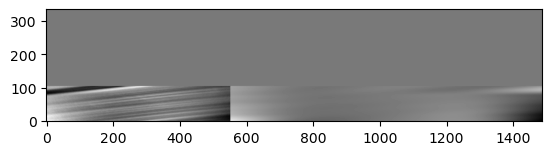

W1630740509


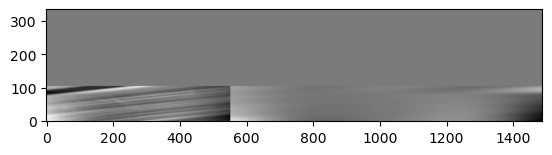

W1630725193


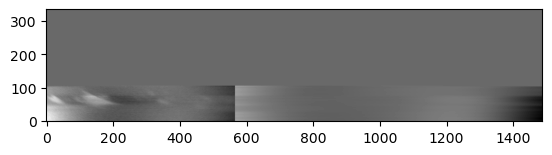

W1630754731


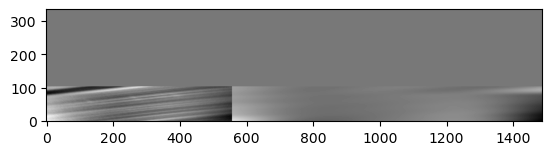

W1630730116


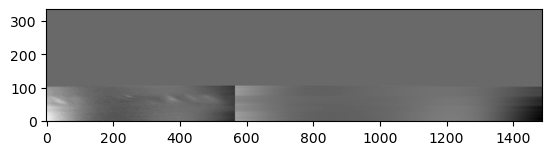

W1630746526


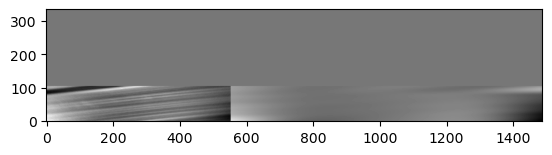

W1630732304


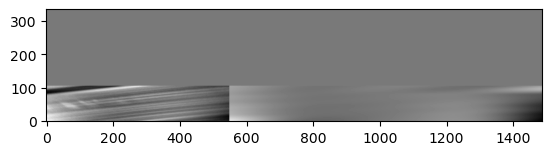

W1630742150


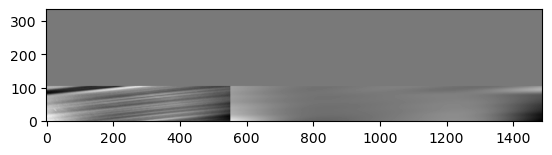

W1630732851


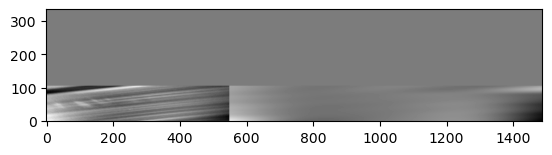

W1630745979


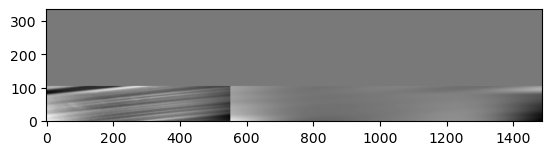

W1630751449


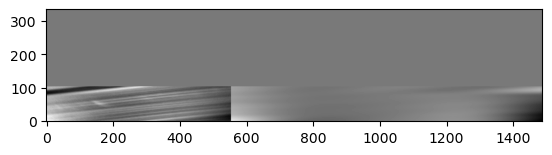

W1630749808


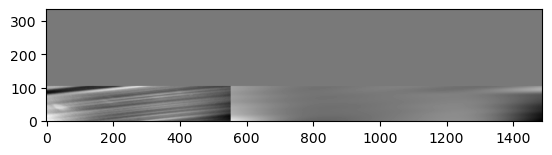

W1630731757


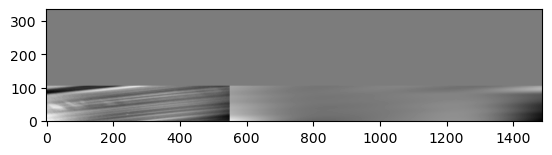

W1630726834


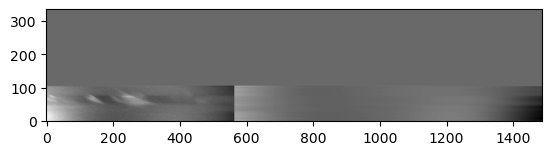

W1630782628


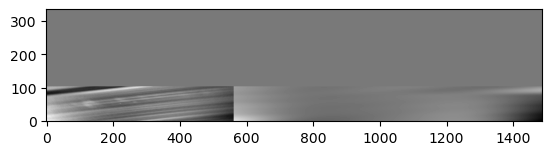

W1630755825


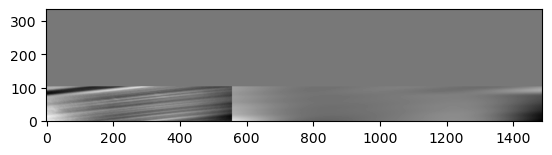

W1630727928


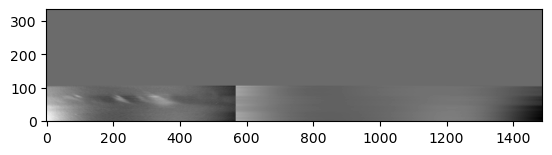

W1630752543


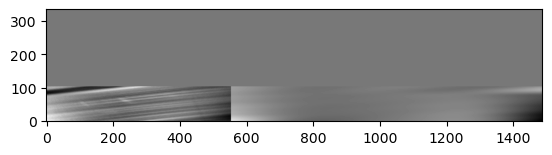

W1630750355


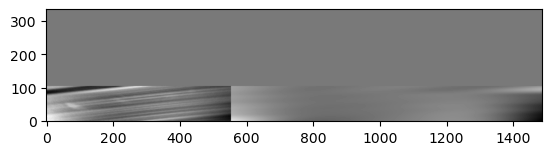

W1630390099


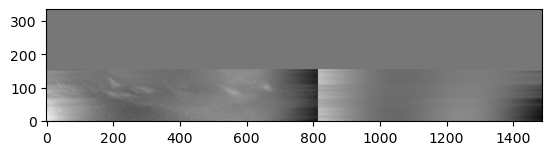

W1630389454


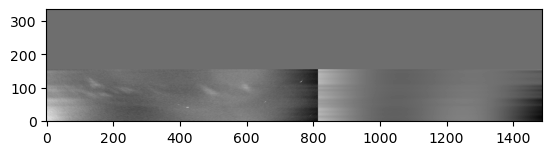

W1630869513


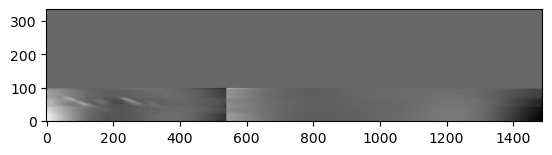

W1630840787


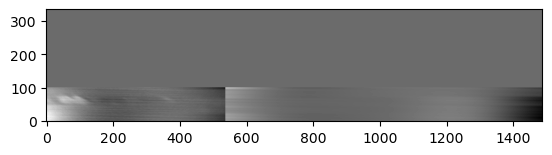

W1630857589


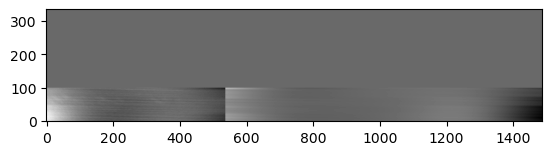

W1630833741


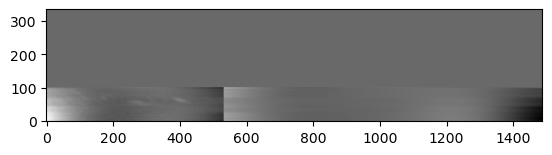

W1630859215


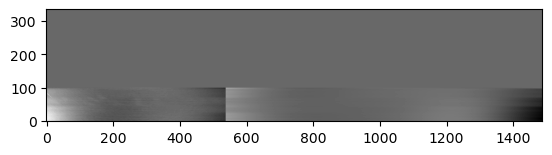

W1630841329


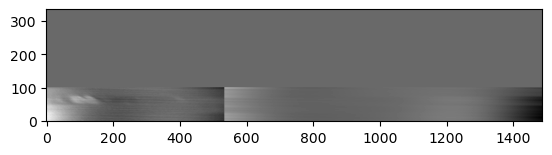

W1630870055


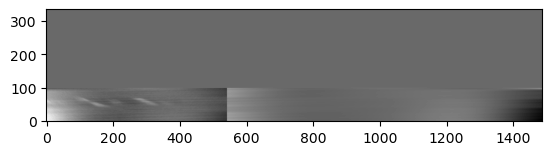

W1630867887


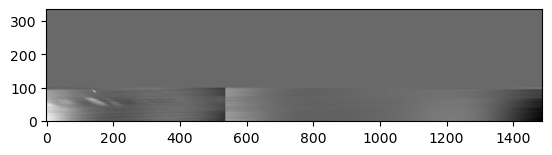

W1630852169


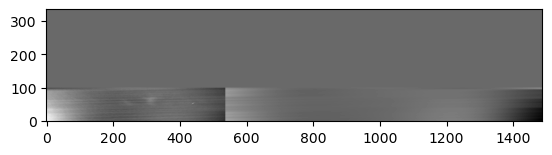

W1630834825


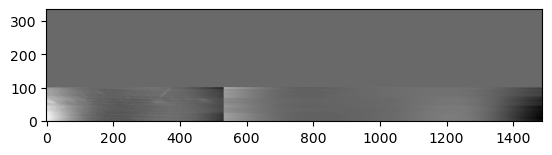

W1630854337


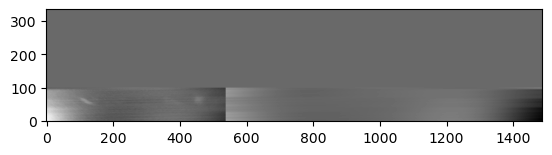

W1630836993


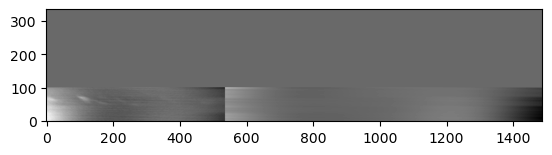

W1630837535


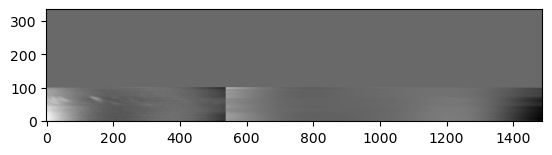

W1630858131


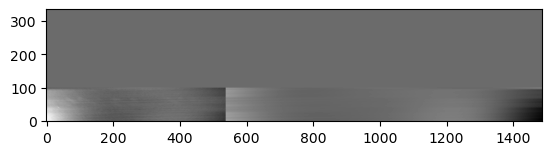

W1630832115


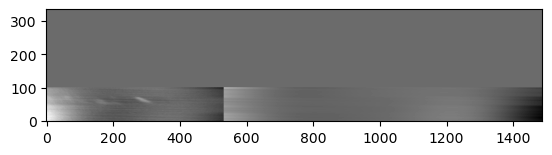

W1630868971


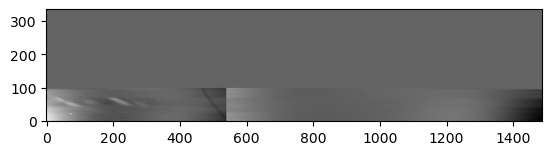

W1630831031


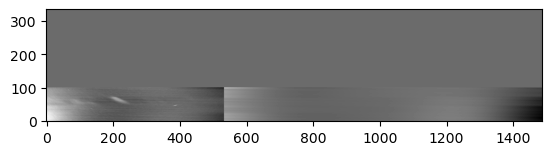

W1630847833


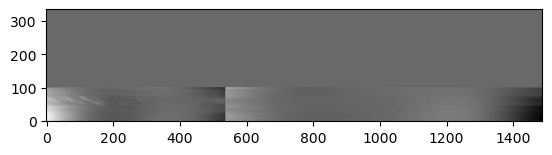

W1630864635


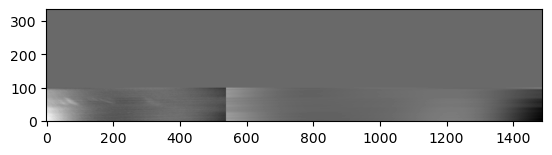

W1630866803


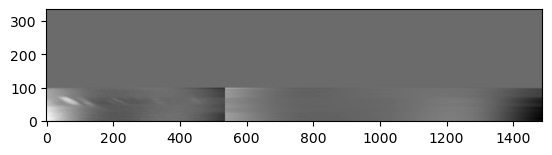

W1630830489


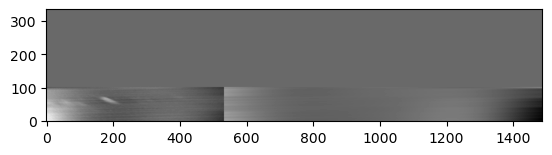

W1630848917


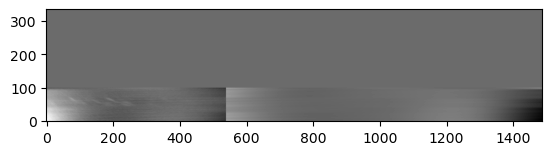

W1630861925


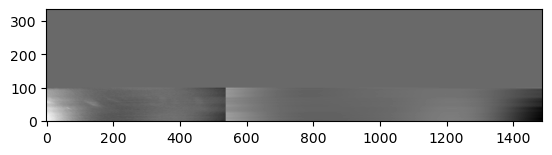

W1630865177


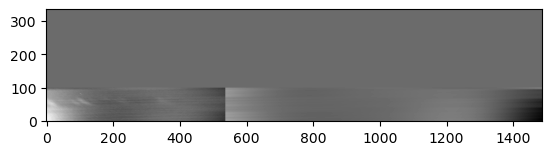

W1630844581


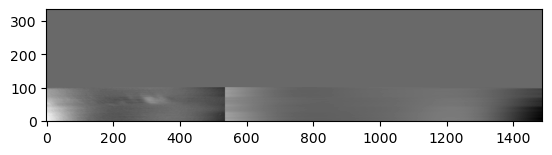

W1630838077


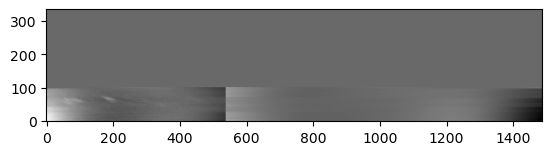

W1630845665


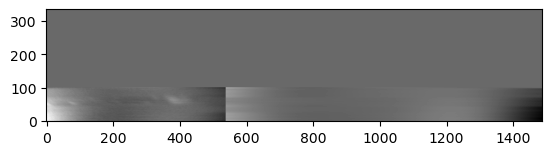

W1630840245


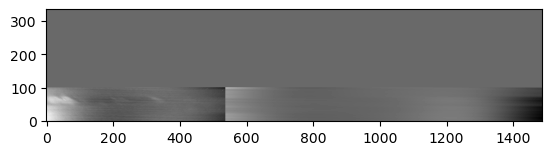

W1630870597


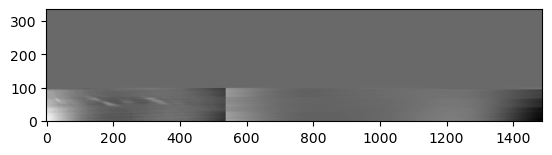

W1630864093


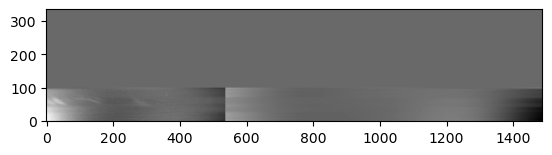

W1630849459


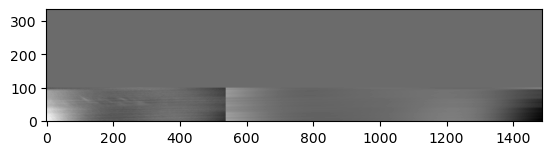

W1630871139


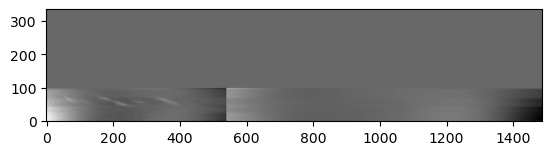

W1630829405


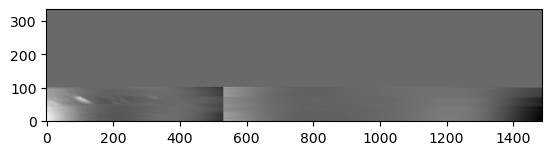

W1630836451


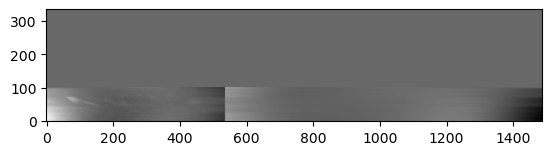

W1630844039


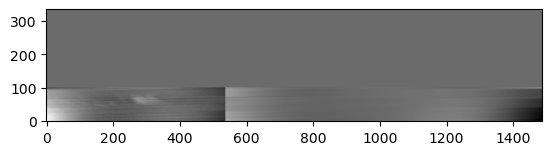

W1630835367


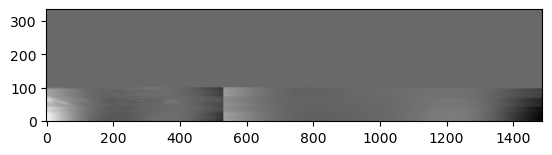

W1630852711


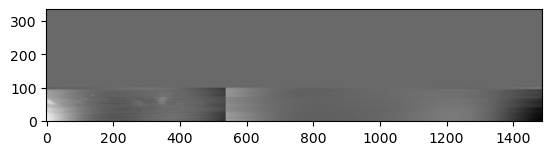

W1630867345


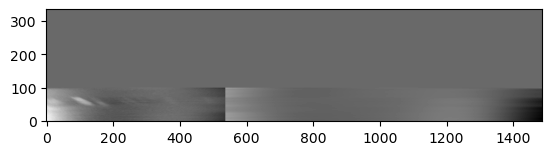

W1630828863


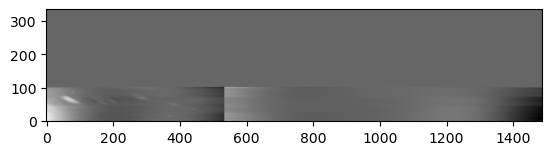

W1630857047


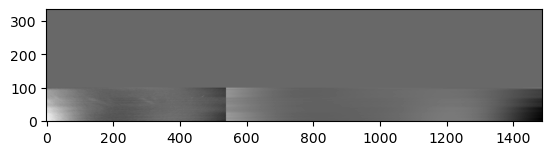

W1630828321


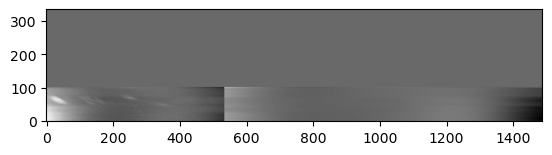

W1630846749


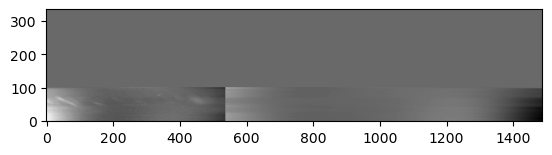

W1630866261


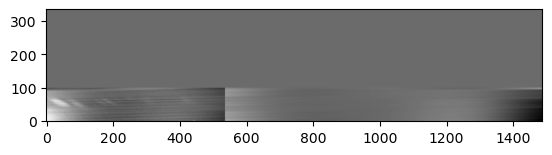

W1630845123


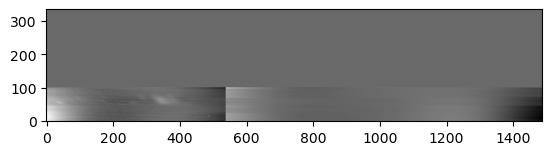

W1630829947


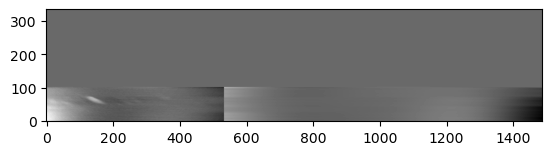

W1630848375


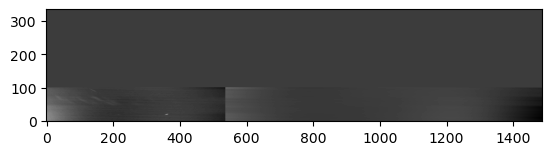

W1630839161


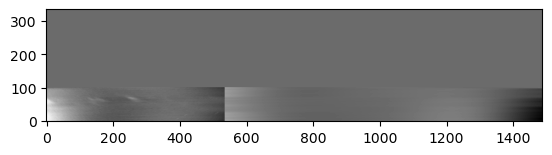

W1630847291


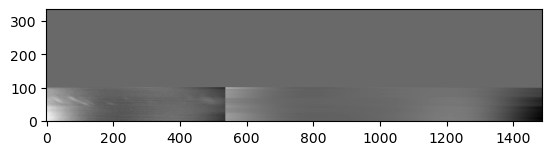

W1630851627


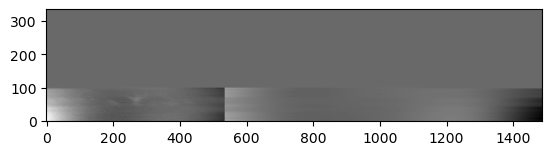

W1630853795


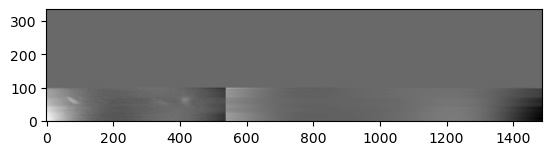

W1630846207


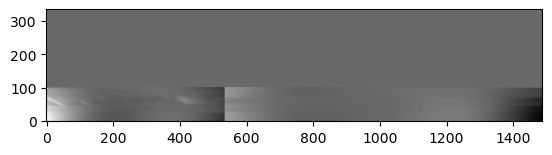

W1630871681


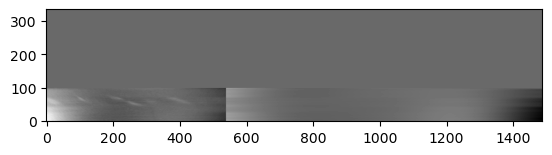

W1630855963


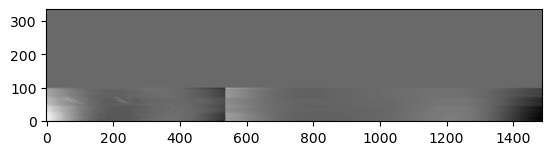

W1630831573


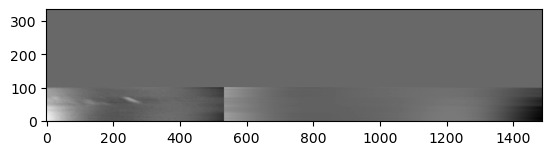

W1630862467


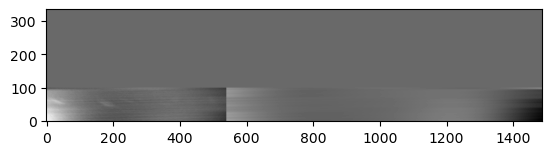

W1630851085


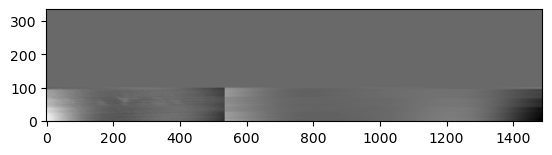

W1630833199


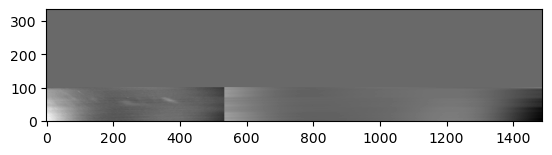

W1630826153


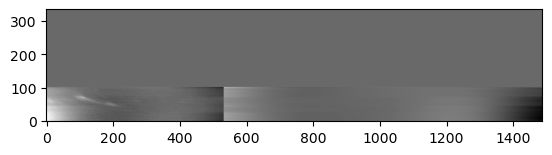

W1630865719


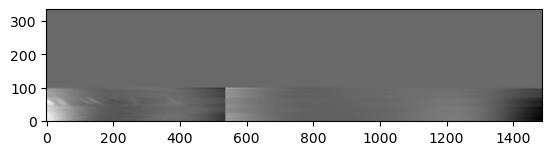

W1630858673


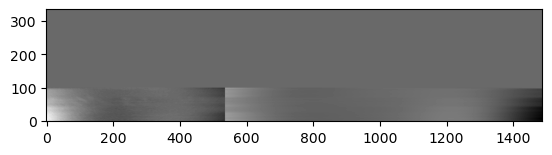

W1630832657


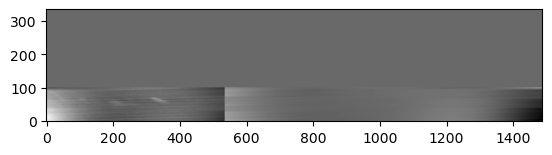

W1630839703


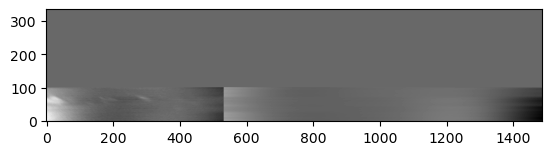

W1630860299


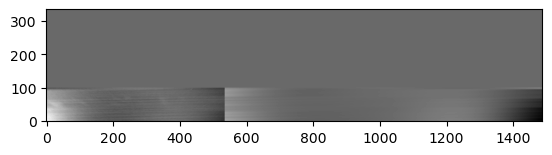

W1630843497


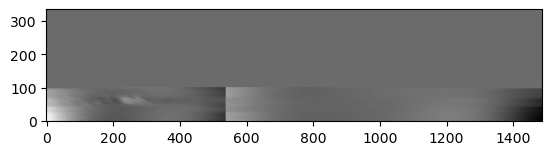

W1630863009


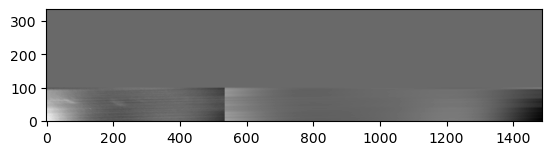

W1630863551


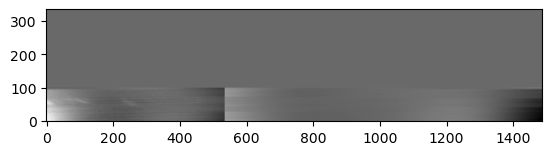

W1630856505


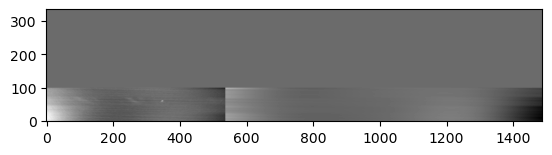

W1630842955


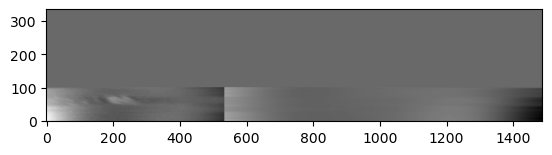

W1630854879


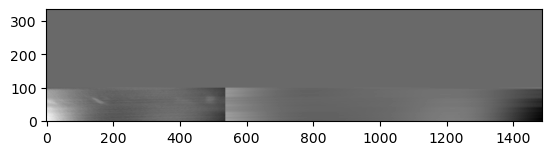

W1630860841


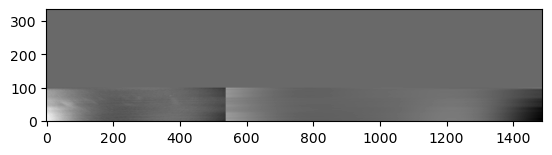

W1630853253


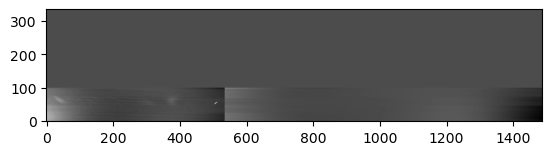

W1630859757


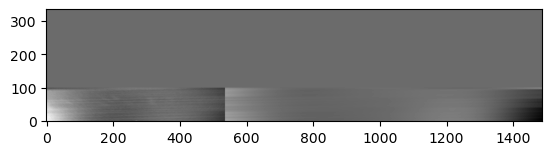

W1630850001


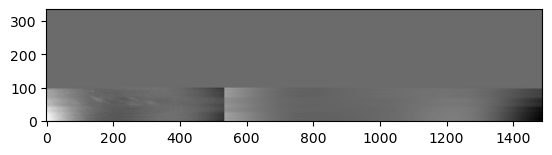

W1630841871


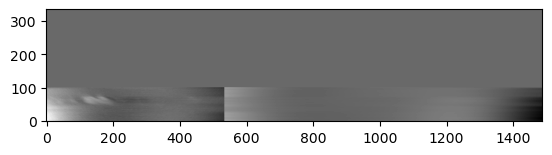

W1630855421


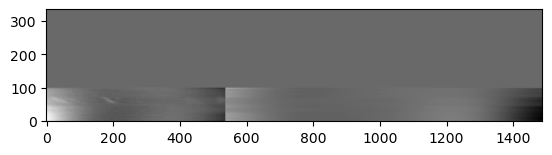

W1630835909


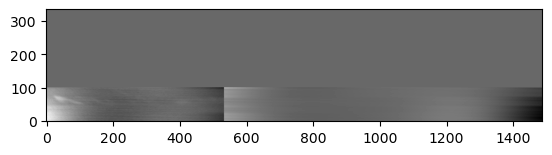

W1630868429


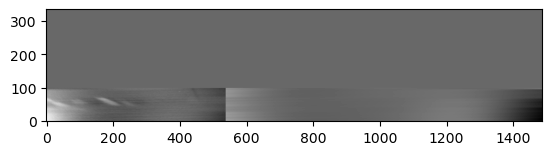

W1630842413


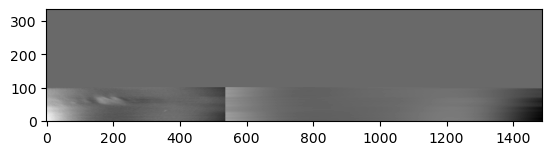

W1630838619


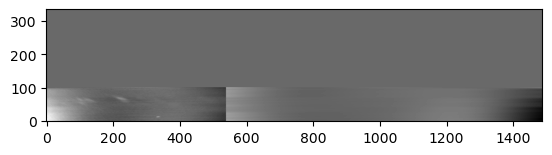

W1630861383


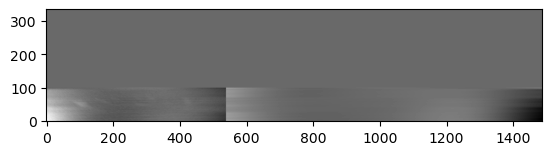

In [31]:
for filepath in bad_rpjb_list:
    filename, pixel_values = preprocess_filter.apply_filter(filepath)
    print(filename)
    plt.imshow(pixel_values, cmap='gray', origin='lower')
    plt.show()

In [34]:
def opusid_to_rpjb_path(opus_id):
    rpjb_path = None

    temp_list = glob.glob(f"../data/2023_rpjb/good/*/{opus_id}*")
    if len(temp_list) == 1:
        rpjb_path = temp_list[0]
    elif len(temp_list) == 0:
        print("path doesn't exist")
    else:
        print("there were multiple!")

    return rpjb_path


In [32]:
odd_images = ["W1630853253","W1630576041","W1630586301","W1630481670","W1630735039"]

In [35]:
odd_rpjb_path = []
for opus_id in odd_images:
    odd_rpjb_path.append(opusid_to_rpjb_path(opus_id))

filepath: ../data/2023_rpjb/good/117_SPKMVLFHP_007/W1630853253_1_CALIB.rpjb ************************
raw
remove cosmic rays


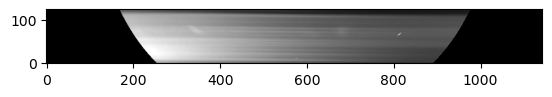

Male all low value pixels 0


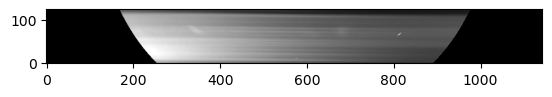

Quant map


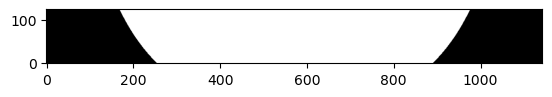

{'x_start': 248, 'x_end': 898, 'biggest_sum': 651, 'y_longst_top': 7}
cropping


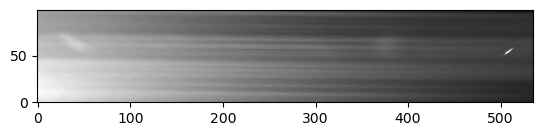

adding buffer


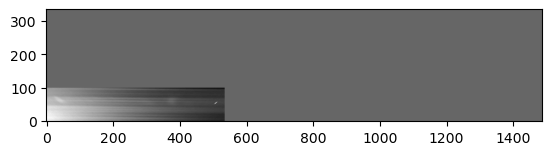

Forrier transform


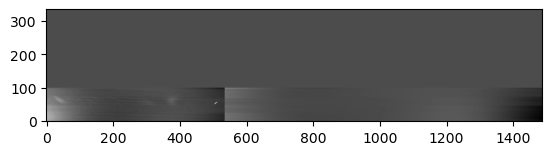

NEW IMAGE ************************************************
filepath: ../data/2023_rpjb/good/117_SPKMVLFHP_004/W1630576041_1_CALIB.rpjb ************************
raw
remove cosmic rays


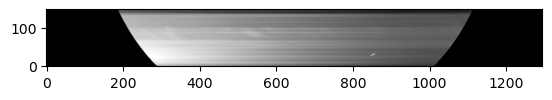

Male all low value pixels 0


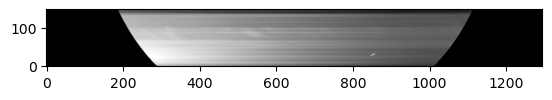

Quant map


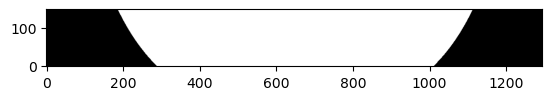

{'x_start': 280, 'x_end': 1021, 'biggest_sum': 742, 'y_longst_top': 9}
cropping


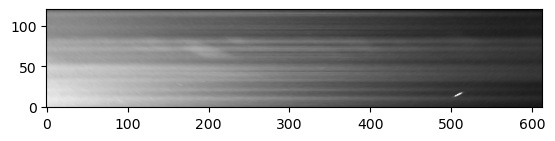

adding buffer


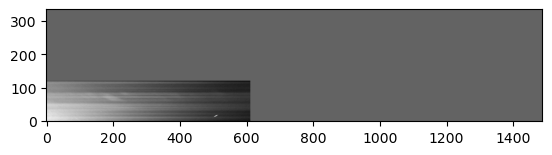

Forrier transform


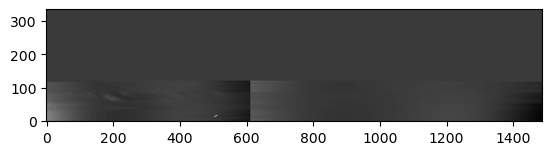

NEW IMAGE ************************************************
filepath: ../data/2023_rpjb/good/117_SPKMVLFHP_004/W1630586301_1_CALIB.rpjb ************************
raw
remove cosmic rays


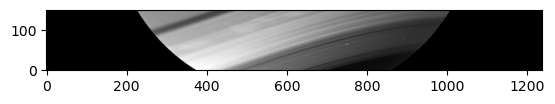

Male all low value pixels 0


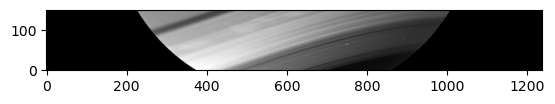

Quant map


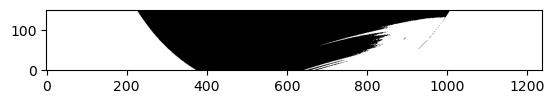

{'x_start': 0, 'x_end': 373, 'biggest_sum': 374, 'y_longst_top': 0}
cropping


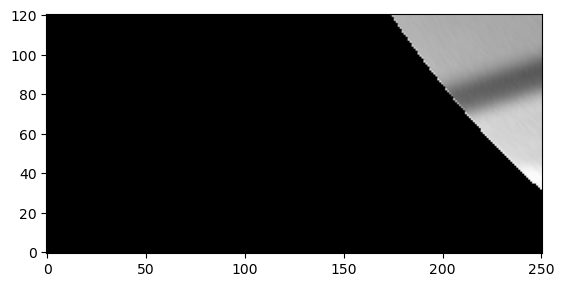

adding buffer


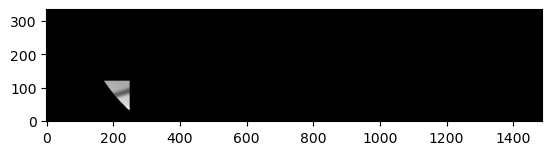

Forrier transform


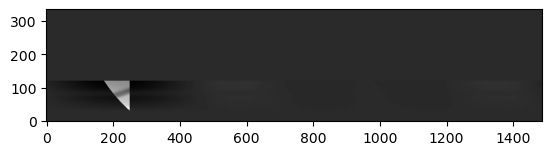

NEW IMAGE ************************************************
filepath: ../data/2023_rpjb/good/117_SPKMVLFHP_003/W1630481670_1_CALIB.rpjb ************************
raw
remove cosmic rays


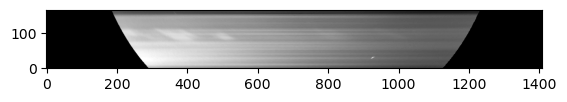

Male all low value pixels 0


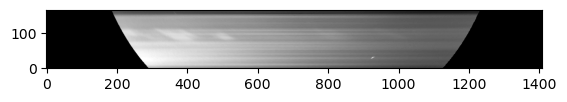

Quant map


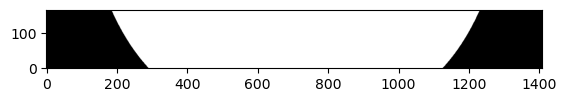

{'x_start': 281, 'x_end': 1136, 'biggest_sum': 856, 'y_longst_top': 11}
cropping


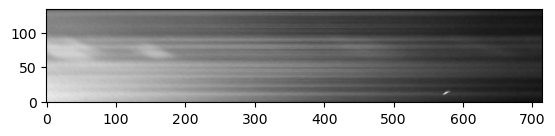

adding buffer


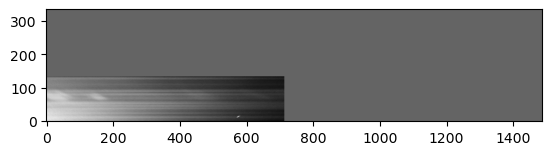

Forrier transform


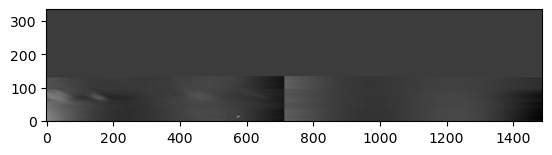

NEW IMAGE ************************************************
filepath: ../data/2023_rpjb/good/117_SPKMVLFHP_006/W1630735039_1_CALIB.rpjb ************************
raw
remove cosmic rays


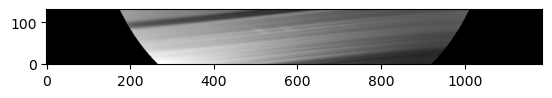

Male all low value pixels 0


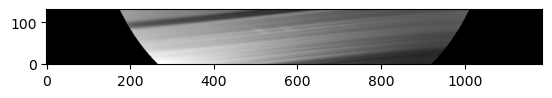

Quant map


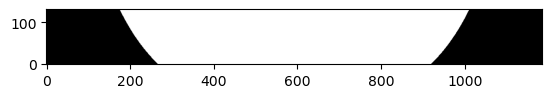

{'x_start': 259, 'x_end': 928, 'biggest_sum': 670, 'y_longst_top': 8}
cropping


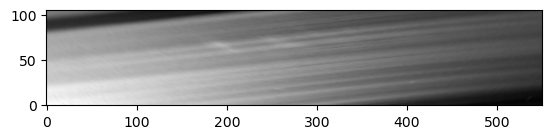

adding buffer


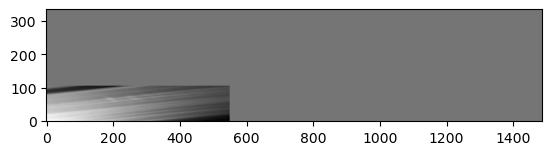

Forrier transform


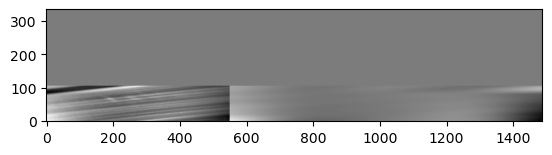

NEW IMAGE ************************************************


In [41]:
for filepath in odd_rpjb_path:
    print(f"filepath: {filepath} ************************")
    idl = io.readsav(filepath)
    bad_pv = idl.rrpi
    bad_pv=copy.copy(bad_pv)
    bad_y, bad_x = bad_pv.shape
    print("raw")
    plt.imshow(bad_pv, cmap='gray', origin='lower')

    print('remove cosmic rays')
    bad_pv = preprocess_filter.remove_cosmic_rays(bad_pv)
    plt.imshow(bad_pv, cmap='gray', origin='lower')
    plt.show()

    flt = bad_pv.flatten()
    p_std = flt.std()
    p_m = flt.mean()
    bad_pv[bad_pv < (p_m - p_std)] = 0

    print('Male all low value pixels 0')
    plt.imshow(bad_pv, cmap='gray', origin='lower')
    plt.show()

    
    # so far, so good
    bad_pv, bad_quant = preprocess_filter.apply_quantize(bad_pv)
    
    print("Quant map")
    plt.imshow(bad_quant, cmap='gray', origin='lower')
    plt.show()

    # it seems that the new remove cosmic ray method has solved the problem. looks, these are perfect
    LS = preprocess_filter.get_quant_stats(bad_quant)
    print(LS)

    
    ybuffer = int(bad_y*.1)
    xbuffer = int(bad_x*.05)
    bad_pv = bad_pv[ybuffer:bad_y-ybuffer, LS["x_start"]+xbuffer:LS["x_end"]-xbuffer]
    print("cropping")
    plt.imshow(bad_pv, cmap='gray', origin='lower')
    plt.show()

    print("adding buffer")
    bad_pv = preprocess_filter.buffer_image(bad_pv, propper_x=1488, propper_y=336)
    plt.imshow(bad_pv, cmap='gray', origin='lower')
    plt.show()

    print("Forrier transform")
    bad_pv = spoketools.fft2lpf(bad_pv,0, 3 )
    plt.imshow(bad_pv, cmap='gray', origin='lower')
    plt.show()
    

    print("NEW IMAGE ************************************************")
    

    
    

# CONCLUSION -  likely cause of the bad cropping was due to the selective removal of cosmic rays, i.e. only removing cosmic rays if they were above a certian brightness. 

#### This condition has been removed and the removal of cosmic rays has been abstracted from the Lucys median filter process. 

#### remove_cosmic_rays now replaces the top 20 brightest pixels in a row with the 21st brightest pixel for every row in an image regardless of how bight the cosmic ray is. 

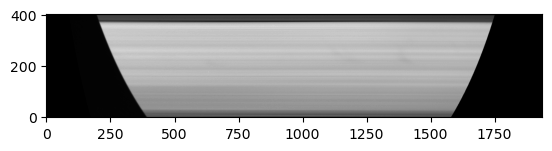

In [42]:
idl = io.readsav('../data/2023_rpjb/good/085_SPKMVLFLP/W1600545658_1_CALIB.rpjb')
good_pv = idl.rrpi
good_pv=copy.copy(good_pv)
good_y, good_x = good_pv.shape
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()

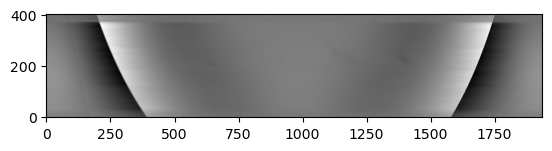

In [43]:
good_pv = preprocess_filter.fft2lpf(good_pv, 0, 3)
plt.imshow(good_pv, cmap='gray', origin='lower')
plt.show()